# Detecting out of distribution images in Cifar10 using Annoy and AutoML

This example shows how to train a neural network image classifier via [AutoGluon AutoML](https://auto.gluon.ai/) and then leverage it for outlier detection with cleanlab. We also demonstrate how to perform outlier detection using feature embeddings with custom K-Nearest-Neighbor implementations beyond ``sklearn``. Here we demonstrate this with the efficient approximate neighbors library [Annoy](https://github.com/spotify/annoy), but a similar strategy can be used to leverage any other KNN library. 

You should be able to use the code here to find outliers in almost any image dataset.


## 1. Load required packages and set seeds for reproducibility

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from autogluon.vision import ImagePredictor, ImageDataset
from annoy import AnnoyIndex
from cleanlab.outlier import OutOfDistribution


SEED = 42
np.random.seed(SEED)
warnings.filterwarnings("ignore", "Lazy modules are a new feature.*")

## 2. Load the Cifar10 dataset

In [ ]:
experiment_path = "./experiment"
if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)
    print("Directory " , experiment_path ,  " Created ")
else:    
    print("Directory " , experiment_path ,  " already exists")

print(f'Experiment saved in {experiment_path}')

In [ ]:
# Download CIFAR-10 data for model training
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/Multiannotator/cifar-10/cifar10_test.tar.gz'
!tar -xzf cifar10_test.tar.gz

# Here is an alternative command to download the data from the source:
# cifar2png cifar10 ./data/cifar10_test --name-with-batch-index

# Import CIFAR-10 labels and image paths
!cd $experiment_path && wget -nc 'https://cleanlab-public.s3.amazonaws.com/Multiannotator/cifar-10h/cifar-10h-worst25-coin20/c10h_image_paths.npy'
!cd $experiment_path && wget -nc 'https://cleanlab-public.s3.amazonaws.com/Multiannotator/cifar-10h/cifar-10h-worst25-coin20/c10h_test_labels.npy'

In [4]:
txt_labels = {0: 'airplane', 
              1: 'automobile', 
              2: 'bird',
              3: 'cat', 
              4: 'deer', 
              5: 'dog', 
              6: 'frog', 
              7: 'horse', 
              8:'ship', 
              9:'truck'}

def imshow(img):
    img = cv2.imread(img)[...,::-1]
    return img

def plot_images(image_paths):
    plt.rcParams["figure.figsize"] = (9,7)
    for i in range(15):
        X = image_paths[i]
        ax = plt.subplot(3,5,i+1)
        ax.imshow(imshow(X))
    plt.show()

Each image in the original cifar10 dataset belongs to 1 of 10 classes: `[airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck]`. After loading the data and processing the images, we manually remove some classes from the training dataset thereby making images from these classes outliers in the test dataset. Here we to remove all classes that are not an animal, such that test images from the following classes would be out-of-distribution: `[airplane, automobile, ship, truck]`.

In [5]:
# Load ground labels and image paths
labels = np.load(f'{experiment_path}/c10h_test_labels.npy')
image_paths = np.load(f'{experiment_path}/c10h_image_paths.npy', allow_pickle=True)
path = os.getcwd()
image_paths = np.array([f"{path}/{image_path}" for image_path in image_paths])

# Split CIFAR-10 dataset into train and test
trainx, testx, trainy, testy = train_test_split(image_paths, labels, test_size=0.15, random_state=SEED)

# Manually remove non-animals out of the training dataset
animal_labels = [2,3,4,5,6,7]
animal_idxs = np.where(np.isin(trainy, animal_labels))[0] # find idx of animals
trainx = trainx[animal_idxs]
trainy = trainy[animal_idxs]

# Zip dataset into format accepted by autogluon
trainset = pd.DataFrame(zip(trainx,trainy), columns=["image", "label"])
testset = pd.DataFrame(zip(testx,testy), columns=["image", "label"])

print('Trainset length: %s' % (len(trainset)))
print('Testset length: %s' % (len(testset)))

Trainset length: 5099
Testset length: 1500


## 3. Train image classification model

Here we fit a neural network for image classification by applying [AutoGluon AutoML](https://auto.gluon.ai/) to our training data (that only contains animal classes).

In [ ]:
model_name = 'resnet18'  # Can train Swin Transformer instead of ResNet via: 'swin_base_patch4_window7_224'

model = ImagePredictor(verbosity=0)
model.fit(
    train_data=trainset,
    ngpus_per_trial=1,
    hyperparameters={"holdout_frac": 0.2, "model": model_name},
    time_limit=7200,  # you can control how long the AutoML trains for
    random_state=12345,
)

From the learned representations of this trained neural network, we can obtain numeric feature embeddings for each image in our datasets:

In [7]:
train_feature_embeddings = model.predict_feature(trainset['image'].to_list())["image_feature"].values
train_feature_embeddings = np.array(train_feature_embeddings.tolist())
test_feature_embeddings = model.predict_feature(testset['image'].to_list())["image_feature"].values
test_feature_embeddings = np.array(test_feature_embeddings.tolist())

## 4. Use cleanlab and `feature_embeddings` to find outliers in the dataset

By default, cleanlab uses the `sklearn.neighbors.NearestNeighbor` class (with *cosine* distance) to find the K nearest neighbors, but you can easily pass in another KNN estimator into cleanlab's `OutOfDistribution` class through its  `params` attribute. [Annoy](https://github.com/spotify/annoy) is an efficient approximate neighbors library that is much more scalable than `sklearn`, so let's use it instead. We simply wrap the Annoy neighbors object into a sklearn-compatible API:

In [8]:
class ApproxNearestNeighbors:
    """ Annoy class that is compatible with sklearn API. """
    def __init__(self, n_neighbors: int = 5, metric: str = "angular", n_trees: int = 10):
        self.ann_index = None
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.n_trees = n_trees
        
    def fit(self, features: np.array):
        dim = features.shape[1]
        self.ann_index = AnnoyIndex(dim, self.metric)
        for i, x in enumerate(features):
            self.ann_index.add_item(i, x)
        self.ann_index.build(self.n_trees)
        return self
    
    def kneighbors(self, features: np.array):
        distances = []
        indices = []
        for x in features:
            idx, dist = self.ann_index.get_nns_by_vector(x, self.n_neighbors, include_distances=True)    
            distances.append(dist)
            indices.append(idx)
        distances = np.array(distances)
        indices = np.array(indices)
        return distances, indices

We can then use this Annoy object to find the nearest neighbors of each image (in feature embedding space).

In [9]:
# Fit knn object on train_feature_embeddings
knn = ApproxNearestNeighbors()
knn.fit(train_feature_embeddings)

Then we can leverage this fitted KNN estimator with cleanlab's `OutOfDistribution` class to find outliers in the data. Below we compute an OOD score for each image in the training data where smaller values near 0 indicate images that are less typical under the data distribution (i.e. outliers). 

In [10]:
OOD = OutOfDistribution(params={"knn": knn})
train_ood_features_scores = OOD.score(features=train_feature_embeddings)

#### Top 15 atypical examples in the training data (based on outlier scores calculated from feature embeddings) 

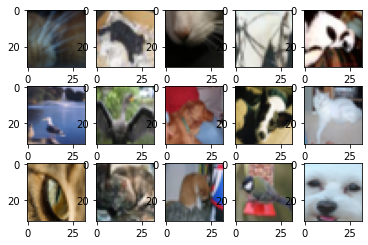

In [11]:
top_train_ood_features_idxs = train_ood_features_scores.argsort()[:15]
top_train_ood_features = trainset.iloc[top_train_ood_features_idxs]["image"].to_list()
plot_images(top_train_ood_features)

Recall our training data solely contains animal images, so these are the strangest looking creatures of the bunch! 
We can also compute out-of-distribution scores for each image in the additional test data, which measure how atypical each image is under the previous training data's distribution.

In [12]:
test_ood_features_scores = OOD.score(features=test_feature_embeddings)

#### Top 15 atypical examples in the test data (based on outlier scores calculated from feature_embeddings) 

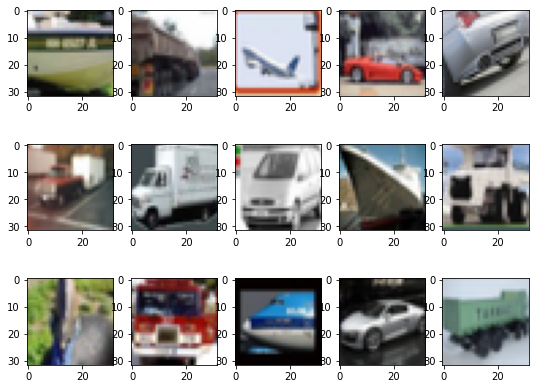

In [13]:
top_test_ood_features_idxs = test_ood_features_scores.argsort()[:15]
top_test_ood_features = testset.iloc[top_test_ood_features_idxs]["image"].to_list()
plot_images(top_test_ood_features)

Note that all the atypical examples belong to the out-of-distribution classes that were absent from our training set (which was entirely composed of animal images).

## 5. Use cleanlab and `pred_probs` to find outliers in the dataset

We sometimes wish to find outliers in classification datasets for which we do not have meaningful numeric feature representations. In this case, cleanlab can detect unusual examples in the data solely using predicted probabilities from a trained classifier. Here we train our same AutoML image classifier using cross-validation, which allows us to generate out-of-sample `pred_probs` for every example in the dataset. These are less biased reflections of the classifier's outputs on previously unseen images.

In [14]:
from utils.model_training import train_model, sum_xval_folds

model_results_folder = "./experiment/model_training"
model_type = "resnet18"  # Can train Swin Transformer instead of ResNet via: "swin_base_patch4_window7_224"

train_args = {
    "num_cv_folds": 5, # decrease this value if you want code to run faster
    "verbose": 0, 
    "epochs": 50, # decrease this value if you want code to run faster
    "time_limit": 7200, # decrease this value if you want code to run faster
    "random_state": 123,
} 

model = train_model(model_type, trainset, model_results_folder, **train_args);

modified configs(<old> != <new>): {
root.img_cls.model   resnet101 != resnet18
root.misc.num_workers 4 != 64
root.misc.seed       42 != 515
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.early_stop_max_value 1.0 != inf
root.train.epochs    200 != 50
}
Saved config to /datasets/ulyana/examples/outlier-detection-cifar10/9304d965/.trial_0/config.yaml


----
Running cross-validation for model: resnet18
----
Running Cross-Validation on Split: 0


Model resnet18 created, param count:                                         11179590
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 192.481777 samples/sec	accuracy=0.183750	lr=0.000100
Epoch[0] Batch [99]	Speed: 834.070317 samples/sec	accuracy=0.208125	lr=0.000100
Epoch[0] Batch [149]	Speed: 865.587323 samples/sec	accuracy=0.223750	lr=0.000100
Epoch[0] Batch [199]	Speed: 850.121725 samples/sec	accuracy=0.243125	lr=0.000100
[Epoch 0] training: accuracy=0.250819
[Epoch 0] speed: 483 samples/sec	time cost: 7.540582
[Epoch 0] validation: top1=0.414216 top5=0.953431
[Epoch 0] Current best top-1: 0.414216 vs previous -inf, saved to /datasets/ulyana/examples/outlier-detection-cifar10/9304d965/.trial_0/best_checkpoint.pkl
Epoch[1] Batch [49]	Speed: 520.200928 samples/sec	accuracy=0.376250	lr=0.003400
Epoch[1] Batch [99]	Speed: 808.883185 samples/sec	accuracy=0.428125	lr=0.003400
Epoch[1] Batch [149]	Sp

[Epoch 14] validation: top1=0.786765 top5=0.990196
Epoch[15] Batch [49]	Speed: 613.903077 samples/sec	accuracy=0.735000	lr=0.010000
Epoch[15] Batch [99]	Speed: 820.008798 samples/sec	accuracy=0.706875	lr=0.010000
Epoch[15] Batch [149]	Speed: 851.647867 samples/sec	accuracy=0.697083	lr=0.010000
Epoch[15] Batch [199]	Speed: 822.354904 samples/sec	accuracy=0.704375	lr=0.010000
[Epoch 15] training: accuracy=0.707969
[Epoch 15] speed: 767 samples/sec	time cost: 4.756268
[Epoch 15] validation: top1=0.823529 top5=0.997549
Epoch[16] Batch [49]	Speed: 617.333351 samples/sec	accuracy=0.745000	lr=0.010000
Epoch[16] Batch [99]	Speed: 821.208110 samples/sec	accuracy=0.746875	lr=0.010000
Epoch[16] Batch [149]	Speed: 853.952924 samples/sec	accuracy=0.741250	lr=0.010000
Epoch[16] Batch [199]	Speed: 817.541963 samples/sec	accuracy=0.727500	lr=0.010000
[Epoch 16] training: accuracy=0.725437
[Epoch 16] speed: 767 samples/sec	time cost: 4.751554
[Epoch 16] validation: top1=0.720588 top5=0.995098
Epoch[17]

[Epoch 30] Current best top-1: 0.857843 vs previous 0.835784, saved to /datasets/ulyana/examples/outlier-detection-cifar10/9304d965/.trial_0/best_checkpoint.pkl
Epoch[31] Batch [49]	Speed: 609.616608 samples/sec	accuracy=0.860000	lr=0.001000
Epoch[31] Batch [99]	Speed: 819.976135 samples/sec	accuracy=0.865000	lr=0.001000
Epoch[31] Batch [149]	Speed: 853.927714 samples/sec	accuracy=0.861667	lr=0.001000
Epoch[31] Batch [199]	Speed: 834.719340 samples/sec	accuracy=0.863750	lr=0.001000
[Epoch 31] training: accuracy=0.862172
[Epoch 31] speed: 769 samples/sec	time cost: 4.741582
[Epoch 31] validation: top1=0.857843 top5=0.997549
Epoch[32] Batch [49]	Speed: 611.739508 samples/sec	accuracy=0.875000	lr=0.001000
Epoch[32] Batch [99]	Speed: 821.745686 samples/sec	accuracy=0.875625	lr=0.001000
Epoch[32] Batch [149]	Speed: 855.526019 samples/sec	accuracy=0.868333	lr=0.001000
Epoch[32] Batch [199]	Speed: 833.909463 samples/sec	accuracy=0.865625	lr=0.001000
[Epoch 32] training: accuracy=0.863537
[Epo

Epoch[47] Batch [99]	Speed: 806.993048 samples/sec	accuracy=0.888750	lr=0.001000
Epoch[47] Batch [149]	Speed: 851.150995 samples/sec	accuracy=0.892500	lr=0.001000
Epoch[47] Batch [199]	Speed: 825.353072 samples/sec	accuracy=0.890000	lr=0.001000
[Epoch 47] training: accuracy=0.893286
[Epoch 47] speed: 762 samples/sec	time cost: 4.784571
[Epoch 47] validation: top1=0.857843 top5=0.992647
Epoch[48] Batch [49]	Speed: 603.523138 samples/sec	accuracy=0.887500	lr=0.001000
Epoch[48] Batch [99]	Speed: 816.038250 samples/sec	accuracy=0.881875	lr=0.001000
Epoch[48] Batch [149]	Speed: 857.244844 samples/sec	accuracy=0.877083	lr=0.001000
Epoch[48] Batch [199]	Speed: 835.008488 samples/sec	accuracy=0.879687	lr=0.001000
[Epoch 48] training: accuracy=0.878821
[Epoch 48] speed: 767 samples/sec	time cost: 4.755649
[Epoch 48] validation: top1=0.860294 top5=0.992647
Epoch[49] Batch [49]	Speed: 617.587527 samples/sec	accuracy=0.893750	lr=0.001000
Epoch[49] Batch [99]	Speed: 825.533186 samples/sec	accuracy=

Saving ./experiment/model_training_resnet18/split_0/_test_pred_probs_split_0
Saving ./experiment/model_training_resnet18/split_0/_test_pred_features_split_0
Saving ./experiment/model_training_resnet18/split_0/_test_labels_split_0
Saving ./experiment/model_training_resnet18/split_0/_test_image_files_split_0
Saving ./experiment/model_training_resnet18/split_0/_test_indices_split_0
----
Running Cross-Validation on Split: 1


Model resnet18 created, param count:                                         11179590
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 187.585189 samples/sec	accuracy=0.182500	lr=0.000100
Epoch[0] Batch [99]	Speed: 827.883479 samples/sec	accuracy=0.214375	lr=0.000100
Epoch[0] Batch [149]	Speed: 845.769255 samples/sec	accuracy=0.228750	lr=0.000100
Epoch[0] Batch [199]	Speed: 826.366144 samples/sec	accuracy=0.253125	lr=0.000100
[Epoch 0] training: accuracy=0.263100
[Epoch 0] speed: 472 samples/sec	time cost: 7.713605
[Epoch 0] validation: top1=0.426471 top5=0.975490
[Epoch 0] Current best top-1: 0.426471 vs previous -inf, saved to /datasets/ulyana/examples/outlier-detection-cifar10/885ada4d/.trial_0/best_checkpoint.pkl
Epoch[1] Batch [49]	Speed: 617.173363 samples/sec	accuracy=0.397500	lr=0.003400
Epoch[1] Batch [99]	Speed: 817.877937 samples/sec	accuracy=0.416250	lr=0.003400
Epoch[1] Batch [149]	Sp

Epoch[15] Batch [99]	Speed: 820.347204 samples/sec	accuracy=0.721250	lr=0.010000
Epoch[15] Batch [149]	Speed: 859.589588 samples/sec	accuracy=0.720833	lr=0.010000
Epoch[15] Batch [199]	Speed: 841.851477 samples/sec	accuracy=0.718437	lr=0.010000
[Epoch 15] training: accuracy=0.718341
[Epoch 15] speed: 774 samples/sec	time cost: 4.708401
[Epoch 15] validation: top1=0.821078 top5=0.997549
[Epoch 15] Current best top-1: 0.821078 vs previous 0.808824, saved to /datasets/ulyana/examples/outlier-detection-cifar10/885ada4d/.trial_0/best_checkpoint.pkl
Epoch[16] Batch [49]	Speed: 607.423930 samples/sec	accuracy=0.733750	lr=0.010000
Epoch[16] Batch [99]	Speed: 821.719727 samples/sec	accuracy=0.731875	lr=0.010000
Epoch[16] Batch [149]	Speed: 854.705327 samples/sec	accuracy=0.734167	lr=0.010000
Epoch[16] Batch [199]	Speed: 829.951889 samples/sec	accuracy=0.731875	lr=0.010000
[Epoch 16] training: accuracy=0.731987
[Epoch 16] speed: 766 samples/sec	time cost: 4.761006
[Epoch 16] validation: top1=0.8

[Epoch 30] validation: top1=0.867647 top5=0.997549
Epoch[31] Batch [49]	Speed: 619.551382 samples/sec	accuracy=0.865000	lr=0.001000
Epoch[31] Batch [99]	Speed: 824.911749 samples/sec	accuracy=0.861250	lr=0.001000
Epoch[31] Batch [149]	Speed: 857.228200 samples/sec	accuracy=0.853750	lr=0.001000
Epoch[31] Batch [199]	Speed: 836.629300 samples/sec	accuracy=0.856250	lr=0.001000
[Epoch 31] training: accuracy=0.854258
[Epoch 31] speed: 773 samples/sec	time cost: 4.714305
[Epoch 31] validation: top1=0.865196 top5=0.997549
Epoch[32] Batch [49]	Speed: 613.467031 samples/sec	accuracy=0.833750	lr=0.001000
Epoch[32] Batch [99]	Speed: 820.747116 samples/sec	accuracy=0.839375	lr=0.001000
Epoch[32] Batch [149]	Speed: 857.532060 samples/sec	accuracy=0.853750	lr=0.001000
Epoch[32] Batch [199]	Speed: 840.891132 samples/sec	accuracy=0.857500	lr=0.001000
[Epoch 32] training: accuracy=0.857806
[Epoch 32] speed: 772 samples/sec	time cost: 4.720835
[Epoch 32] validation: top1=0.884804 top5=0.997549
[Epoch 32

Epoch[46] Batch [149]	Speed: 854.703150 samples/sec	accuracy=0.882500	lr=0.001000
Epoch[46] Batch [199]	Speed: 841.710199 samples/sec	accuracy=0.879687	lr=0.001000
[Epoch 46] training: accuracy=0.879367
[Epoch 46] speed: 777 samples/sec	time cost: 4.692307
[Epoch 46] validation: top1=0.897059 top5=0.997549
Epoch[47] Batch [49]	Speed: 622.723915 samples/sec	accuracy=0.886250	lr=0.001000
Epoch[47] Batch [99]	Speed: 824.317369 samples/sec	accuracy=0.894375	lr=0.001000
Epoch[47] Batch [149]	Speed: 862.982454 samples/sec	accuracy=0.897083	lr=0.001000
Epoch[47] Batch [199]	Speed: 838.148165 samples/sec	accuracy=0.891563	lr=0.001000
[Epoch 47] training: accuracy=0.893286
[Epoch 47] speed: 776 samples/sec	time cost: 4.696244
[Epoch 47] validation: top1=0.901961 top5=0.997549
Epoch[48] Batch [49]	Speed: 613.431703 samples/sec	accuracy=0.877500	lr=0.001000
Epoch[48] Batch [99]	Speed: 818.822974 samples/sec	accuracy=0.882500	lr=0.001000
Epoch[48] Batch [149]	Speed: 864.815201 samples/sec	accuracy

Saving ./experiment/model_training_resnet18/split_1/_test_pred_probs_split_1
Saving ./experiment/model_training_resnet18/split_1/_test_pred_features_split_1
Saving ./experiment/model_training_resnet18/split_1/_test_labels_split_1
Saving ./experiment/model_training_resnet18/split_1/_test_image_files_split_1
Saving ./experiment/model_training_resnet18/split_1/_test_indices_split_1
----
Running Cross-Validation on Split: 2


Model resnet18 created, param count:                                         11179590
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 188.818460 samples/sec	accuracy=0.192500	lr=0.000100
Epoch[0] Batch [99]	Speed: 831.548372 samples/sec	accuracy=0.213125	lr=0.000100
Epoch[0] Batch [149]	Speed: 853.302952 samples/sec	accuracy=0.238750	lr=0.000100
Epoch[0] Batch [199]	Speed: 842.749880 samples/sec	accuracy=0.260000	lr=0.000100
[Epoch 0] training: accuracy=0.271834
[Epoch 0] speed: 476 samples/sec	time cost: 7.652240
[Epoch 0] validation: top1=0.404412 top5=0.948529
[Epoch 0] Current best top-1: 0.404412 vs previous -inf, saved to /datasets/ulyana/examples/outlier-detection-cifar10/f8b28a92/.trial_0/best_checkpoint.pkl
Epoch[1] Batch [49]	Speed: 621.366633 samples/sec	accuracy=0.391250	lr=0.003400
Epoch[1] Batch [99]	Speed: 813.540570 samples/sec	accuracy=0.424375	lr=0.003400
Epoch[1] Batch [149]	Sp

Epoch[15] Batch [99]	Speed: 822.315604 samples/sec	accuracy=0.740625	lr=0.010000
Epoch[15] Batch [149]	Speed: 861.095580 samples/sec	accuracy=0.728333	lr=0.010000
Epoch[15] Batch [199]	Speed: 838.966300 samples/sec	accuracy=0.728437	lr=0.010000
[Epoch 15] training: accuracy=0.731987
[Epoch 15] speed: 776 samples/sec	time cost: 4.700428
[Epoch 15] validation: top1=0.830882 top5=0.995098
[Epoch 15] Current best top-1: 0.830882 vs previous 0.794118, saved to /datasets/ulyana/examples/outlier-detection-cifar10/f8b28a92/.trial_0/best_checkpoint.pkl
Epoch[16] Batch [49]	Speed: 630.559195 samples/sec	accuracy=0.758750	lr=0.010000
Epoch[16] Batch [99]	Speed: 828.326148 samples/sec	accuracy=0.748125	lr=0.010000
Epoch[16] Batch [149]	Speed: 858.782844 samples/sec	accuracy=0.745833	lr=0.010000
Epoch[16] Batch [199]	Speed: 842.970915 samples/sec	accuracy=0.736563	lr=0.010000
[Epoch 16] training: accuracy=0.737991
[Epoch 16] speed: 779 samples/sec	time cost: 4.679789
[Epoch 16] validation: top1=0.8

Epoch[31] Batch [149]	Speed: 860.947548 samples/sec	accuracy=0.836667	lr=0.001000
Epoch[31] Batch [199]	Speed: 843.655717 samples/sec	accuracy=0.836875	lr=0.001000
[Epoch 31] training: accuracy=0.837609
[Epoch 31] speed: 774 samples/sec	time cost: 4.712977
[Epoch 31] validation: top1=0.889706 top5=0.995098
[Epoch 31] Current best top-1: 0.889706 vs previous 0.879902, saved to /datasets/ulyana/examples/outlier-detection-cifar10/f8b28a92/.trial_0/best_checkpoint.pkl
Epoch[32] Batch [49]	Speed: 620.686190 samples/sec	accuracy=0.856250	lr=0.001000
Epoch[32] Batch [99]	Speed: 823.464485 samples/sec	accuracy=0.867500	lr=0.001000
Epoch[32] Batch [149]	Speed: 855.433978 samples/sec	accuracy=0.866250	lr=0.001000
Epoch[32] Batch [199]	Speed: 831.005718 samples/sec	accuracy=0.870938	lr=0.001000
[Epoch 32] training: accuracy=0.871179
[Epoch 32] speed: 773 samples/sec	time cost: 4.716500
[Epoch 32] validation: top1=0.887255 top5=0.995098
Epoch[33] Batch [49]	Speed: 629.757764 samples/sec	accuracy=0

Saving ./experiment/model_training_resnet18/split_2/_test_pred_probs_split_2
Saving ./experiment/model_training_resnet18/split_2/_test_pred_features_split_2
Saving ./experiment/model_training_resnet18/split_2/_test_labels_split_2
Saving ./experiment/model_training_resnet18/split_2/_test_image_files_split_2
Saving ./experiment/model_training_resnet18/split_2/_test_indices_split_2
----
Running Cross-Validation on Split: 3


Model resnet18 created, param count:                                         11179590
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 184.429784 samples/sec	accuracy=0.173750	lr=0.000100
Epoch[0] Batch [99]	Speed: 830.355469 samples/sec	accuracy=0.204375	lr=0.000100
Epoch[0] Batch [149]	Speed: 845.981426 samples/sec	accuracy=0.224583	lr=0.000100
Epoch[0] Batch [199]	Speed: 832.731273 samples/sec	accuracy=0.246250	lr=0.000100
[Epoch 0] training: accuracy=0.254640
[Epoch 0] speed: 468 samples/sec	time cost: 7.779661
[Epoch 0] validation: top1=0.406863 top5=0.943627
[Epoch 0] Current best top-1: 0.406863 vs previous -inf, saved to /datasets/ulyana/examples/outlier-detection-cifar10/e216de88/.trial_0/best_checkpoint.pkl
Epoch[1] Batch [49]	Speed: 609.618159 samples/sec	accuracy=0.405000	lr=0.003400
Epoch[1] Batch [99]	Speed: 816.441321 samples/sec	accuracy=0.424375	lr=0.003400
Epoch[1] Batch [149]	Sp

[Epoch 14] validation: top1=0.808824 top5=0.995098
Epoch[15] Batch [49]	Speed: 609.631117 samples/sec	accuracy=0.758750	lr=0.010000
Epoch[15] Batch [99]	Speed: 818.107459 samples/sec	accuracy=0.762500	lr=0.010000
Epoch[15] Batch [149]	Speed: 860.887908 samples/sec	accuracy=0.760417	lr=0.010000
Epoch[15] Batch [199]	Speed: 840.439566 samples/sec	accuracy=0.752188	lr=0.010000
[Epoch 15] training: accuracy=0.747271
[Epoch 15] speed: 771 samples/sec	time cost: 4.727952
[Epoch 15] validation: top1=0.825980 top5=0.997549
[Epoch 15] Current best top-1: 0.825980 vs previous 0.821078, saved to /datasets/ulyana/examples/outlier-detection-cifar10/e216de88/.trial_0/best_checkpoint.pkl
Epoch[16] Batch [49]	Speed: 616.329830 samples/sec	accuracy=0.761250	lr=0.010000
Epoch[16] Batch [99]	Speed: 829.665821 samples/sec	accuracy=0.742500	lr=0.010000
Epoch[16] Batch [149]	Speed: 863.048156 samples/sec	accuracy=0.745417	lr=0.010000
Epoch[16] Batch [199]	Speed: 842.614860 samples/sec	accuracy=0.744062	lr=0

Saving ./experiment/model_training_resnet18/split_3/_test_pred_probs_split_3
Saving ./experiment/model_training_resnet18/split_3/_test_pred_features_split_3
Saving ./experiment/model_training_resnet18/split_3/_test_labels_split_3
Saving ./experiment/model_training_resnet18/split_3/_test_image_files_split_3
Saving ./experiment/model_training_resnet18/split_3/_test_indices_split_3
----
Running Cross-Validation on Split: 4


Model resnet18 created, param count:                                         11179590
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 187.546983 samples/sec	accuracy=0.176250	lr=0.000100
Epoch[0] Batch [99]	Speed: 828.185285 samples/sec	accuracy=0.205625	lr=0.000100
Epoch[0] Batch [149]	Speed: 866.920637 samples/sec	accuracy=0.214583	lr=0.000100
Epoch[0] Batch [199]	Speed: 844.366704 samples/sec	accuracy=0.231875	lr=0.000100
[Epoch 0] training: accuracy=0.243723
[Epoch 0] speed: 476 samples/sec	time cost: 7.659664
[Epoch 0] validation: top1=0.360294 top5=0.943627
[Epoch 0] Current best top-1: 0.360294 vs previous -inf, saved to /datasets/ulyana/examples/outlier-detection-cifar10/5e2e8850/.trial_0/best_checkpoint.pkl
Epoch[1] Batch [49]	Speed: 604.702795 samples/sec	accuracy=0.418750	lr=0.003400
Epoch[1] Batch [99]	Speed: 824.847466 samples/sec	accuracy=0.432500	lr=0.003400
Epoch[1] Batch [149]	Sp

[Epoch 14] validation: top1=0.813725 top5=1.000000
[Epoch 14] Current best top-1: 0.813725 vs previous 0.806373, saved to /datasets/ulyana/examples/outlier-detection-cifar10/5e2e8850/.trial_0/best_checkpoint.pkl
Epoch[15] Batch [49]	Speed: 616.266327 samples/sec	accuracy=0.758750	lr=0.010000
Epoch[15] Batch [99]	Speed: 821.027869 samples/sec	accuracy=0.743750	lr=0.010000
Epoch[15] Batch [149]	Speed: 856.368614 samples/sec	accuracy=0.728750	lr=0.010000
Epoch[15] Batch [199]	Speed: 834.021391 samples/sec	accuracy=0.723437	lr=0.010000
[Epoch 15] training: accuracy=0.726528
[Epoch 15] speed: 771 samples/sec	time cost: 4.735445
[Epoch 15] validation: top1=0.767157 top5=0.997549
Epoch[16] Batch [49]	Speed: 611.626551 samples/sec	accuracy=0.706250	lr=0.010000
Epoch[16] Batch [99]	Speed: 820.159723 samples/sec	accuracy=0.706250	lr=0.010000
Epoch[16] Batch [149]	Speed: 865.332846 samples/sec	accuracy=0.713750	lr=0.010000
Epoch[16] Batch [199]	Speed: 843.744180 samples/sec	accuracy=0.712500	lr=0

Epoch[31] Batch [49]	Speed: 617.234328 samples/sec	accuracy=0.845000	lr=0.001000
Epoch[31] Batch [99]	Speed: 825.270047 samples/sec	accuracy=0.844375	lr=0.001000
Epoch[31] Batch [149]	Speed: 855.762320 samples/sec	accuracy=0.851250	lr=0.001000
Epoch[31] Batch [199]	Speed: 833.082746 samples/sec	accuracy=0.855313	lr=0.001000
[Epoch 31] training: accuracy=0.853712
[Epoch 31] speed: 772 samples/sec	time cost: 4.730261
[Epoch 31] validation: top1=0.852941 top5=0.997549
[Epoch 31] Current best top-1: 0.852941 vs previous 0.850490, saved to /datasets/ulyana/examples/outlier-detection-cifar10/5e2e8850/.trial_0/best_checkpoint.pkl
Epoch[32] Batch [49]	Speed: 613.506402 samples/sec	accuracy=0.851250	lr=0.001000
Epoch[32] Batch [99]	Speed: 835.373117 samples/sec	accuracy=0.848125	lr=0.001000
Epoch[32] Batch [149]	Speed: 861.408380 samples/sec	accuracy=0.852917	lr=0.001000
Epoch[32] Batch [199]	Speed: 840.481458 samples/sec	accuracy=0.850625	lr=0.001000
[Epoch 32] training: accuracy=0.852620
[Epo

[Epoch 46] speed: 779 samples/sec	time cost: 4.677853
[Epoch 46] validation: top1=0.860294 top5=0.995098
Epoch[47] Batch [49]	Speed: 624.498666 samples/sec	accuracy=0.885000	lr=0.001000
Epoch[47] Batch [99]	Speed: 823.684617 samples/sec	accuracy=0.894375	lr=0.001000
Epoch[47] Batch [149]	Speed: 858.302423 samples/sec	accuracy=0.885417	lr=0.001000
Epoch[47] Batch [199]	Speed: 835.993968 samples/sec	accuracy=0.885312	lr=0.001000
[Epoch 47] training: accuracy=0.887009
[Epoch 47] speed: 776 samples/sec	time cost: 4.697074
[Epoch 47] validation: top1=0.870098 top5=0.997549
Epoch[48] Batch [49]	Speed: 615.162382 samples/sec	accuracy=0.877500	lr=0.001000
Epoch[48] Batch [99]	Speed: 829.059862 samples/sec	accuracy=0.891875	lr=0.001000
Epoch[48] Batch [149]	Speed: 865.071382 samples/sec	accuracy=0.888333	lr=0.001000
Epoch[48] Batch [199]	Speed: 841.037616 samples/sec	accuracy=0.885938	lr=0.001000
[Epoch 48] training: accuracy=0.882642
[Epoch 48] speed: 776 samples/sec	time cost: 4.699797
[Epoch

Saving ./experiment/model_training_resnet18/split_4/_test_pred_probs_split_4
Saving ./experiment/model_training_resnet18/split_4/_test_pred_features_split_4
Saving ./experiment/model_training_resnet18/split_4/_test_labels_split_4
Saving ./experiment/model_training_resnet18/split_4/_test_image_files_split_4
Saving ./experiment/model_training_resnet18/split_4/_test_indices_split_4


After training via cross-validation, we compute out-of-sample predicted class probabilities for every image in our training data (which only contained animal images).

In [15]:
train_pred_probs, labels, images = sum_xval_folds(model_type, model_results_folder, **train_args)

We also compute predicted probabilities for every image in the test data, here simply using the model from our final fold of cross-validation.

In [16]:
test_pred_probs = np.array(model.predict_proba(testset['image'].to_list()))

Now we can use cleanlab to score outliers based on `pred_probs` instead of feature embeddings. We MUST zero index our class labels to be integers from 0,1,...,K-1 in order for cleanlab to properly work!

In [17]:
# Zero index train labels
train_labels = trainset['label'].values
train_labels = np.unique(train_labels, return_inverse=True)[1]

# Compute outlier scores for train data (must fit OOD estimator)
OOD = OutOfDistribution()
train_ood_predictions_scores = OOD.fit_score(pred_probs=train_pred_probs, labels=train_labels)

# Compute outlier scores for test data (OOD estimator already fit)
test_ood_predictions_scores = OOD.score(pred_probs=test_pred_probs)

Fitting OOD estimator based on provided pred_probs ...


#### Top 15 atypical examples in the training data (based on outlier scores calculated from out-of-sample  `pred_probs`) 

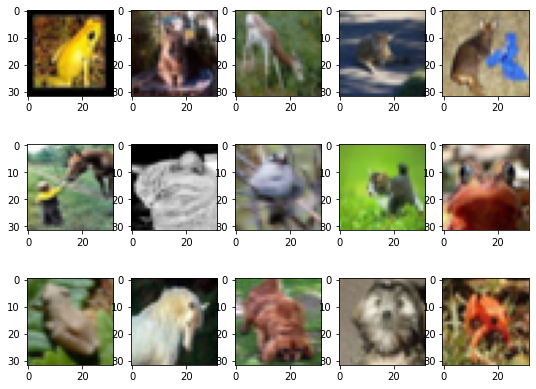

In [18]:
top_train_idxs = train_ood_predictions_scores.argsort()[:15]
top_train_images = trainset.iloc[top_train_idxs]["image"].to_list()
plot_images(top_train_images)

#### Top 15 atypical examples in the test data (based on outlier scores calculated from `pred_probs`)

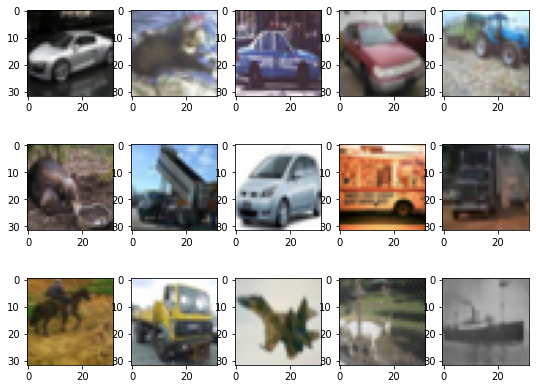

In [19]:
top_test_idxs = test_ood_predictions_scores.argsort()[:15]
top_test_images = testset.iloc[top_test_idxs]["image"].to_list()
plot_images(top_test_images)

Notice how most of these lowest scoring examples come from the out-of-distribution (non animal) classes.